## 1. Training
My training contains the following steps:
1. Prepare a balanced data set to avoid classifier overfitting to one class.
1. Collect different features (color/gradient/HOG) from images.
1. Split data set to training set and testing set.
1. Normalise these features to avoid certain features dominating the classifier.
1. Train a linear SVM classifier to classify samples as cars or non-cars.

## 1.1 Prepare balanced training set and testing set to avoid classifier overfitting to one class

In [1]:
import cv2
import glob
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Divide up into cars and notcars
cars = glob.glob('vehicles/*/*.png')
not_cars = glob.glob('non-vehicles/*/*.png')

# Random pick one from each set to inspect
rand_ind = np.random.randint(0, len(cars))
rand_car_img = mpimg.imread(cars[rand_ind])
rand_ind = np.random.randint(0, len(not_cars))
rand_not_car_img = mpimg.imread(not_cars[rand_ind])

figure, axs = plt.subplots(1, 2)
axs[0].set_title('Sample of Car Image')
axs[0].imshow(rand_car_img)
axs[1].title('Sample of Non-Car Image')
axs[1].imshow(rand_not_car_img)

plt.figure()
plt.bar([0, 1], [len(cars), len(not_cars)])
plt.xticks([0, 1], ['Vehicles', 'Non-Vehicles'])

/home/cli/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


([<matplotlib.axis.XTick at 0x7f3cca6f2c88>,
 <a list of 2 Text xticklabel objects>)

The diagram suggests that we have roughtly the same number of vehicle images and non-vehicle images. Now let's split them into training set and testing set.

## 1.2 Collect different features (color/gradient/HOG) from images.

In [95]:
# Define a function to return HOG features and visualization
# Utility function from Udacity
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a single image
# Modified Utility function from Udacity
def extract_image_features(image, cspace='RGB', orient=9, 
                           pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=feature_vec))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
    
    return hog_features


# Define a function to extract features from a list of images
# Modified Utility function from Udacity
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        hog_features = extract_image_features(image, cspace=colorspace, orient=orient, 
                                              pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                              hog_channel=hog_channel)
        features.append(hog_features)
    # Return list of feature vectors
    return features

97.02 Seconds to extract HOG features...


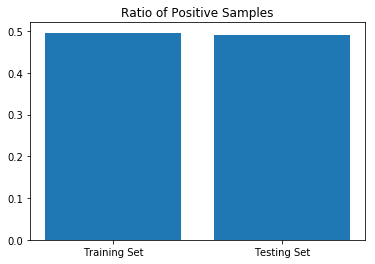

Using: 18 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 10584
4.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9859


In [118]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 18
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
notcar_features = extract_features(not_cars, cspace=colorspace, orient=orient, 
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=rand_state)

plt.title('Ratio of Positive Samples')
positives_train = np.count_nonzero(y_train) / len(y_train)
positives_test  = np.count_nonzero(y_test) / len(y_test)
plt.bar([0, 1], [positives_train, positives_test])
plt.xticks([0, 1], ['Training Set', 'Testing Set'])
plt.show()

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Now try to predict on some test images.

[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
[ 1.  1.  1.  1.  1.  0.  0.  0.  0.  0.]
0.00221 Seconds to predict 10 labels with SVC


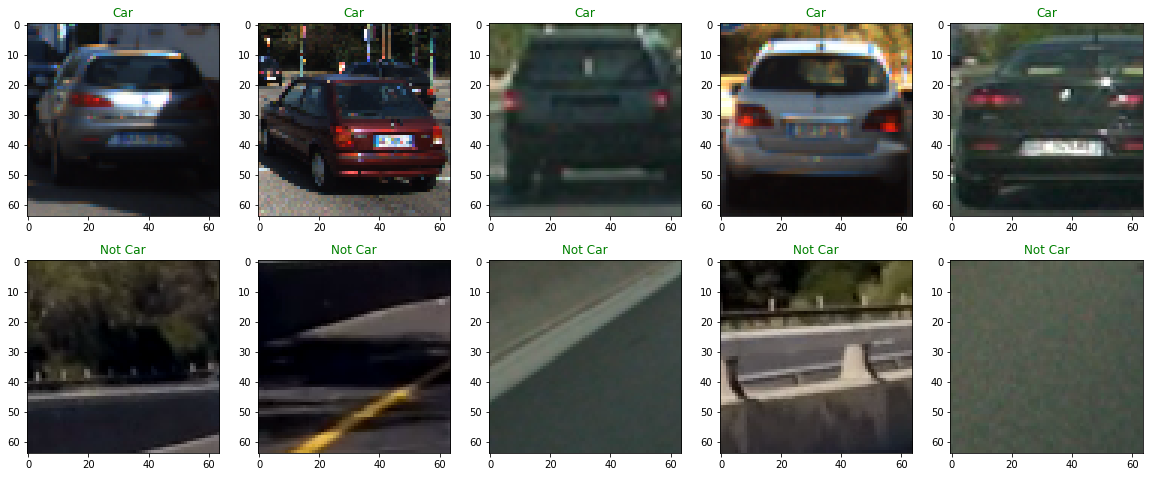

In [119]:
n_predict = 5

random_car_indices = (np.random.rand(n_predict) * len(cars)).astype(int)
random_cars = np.take(np.array(cars), random_car_indices)
random_not_car_indices = (np.random.rand(n_predict) * len(not_cars)).astype(int)
random_not_cars = np.take(np.array(not_cars), random_car_indices)

randoms = np.concatenate((random_cars, random_not_cars), axis=None)
random_features = extract_features(randoms, cspace=colorspace, orient=orient, 
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel)
t=time.time()
X_random = np.vstack((random_features)).astype(np.float64)
X_random = X_scaler.transform(X_random)
y_test = np.concatenate((np.ones(n_predict), np.zeros(n_predict)), axis=None)
y_predict = svc.predict(X_random)
print(y_test)
print(y_predict)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict * 2,'labels with SVC')

fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i in range(n_predict * 2):
    subax = ax[int(i / n_predict)][int(i % n_predict)]
    color = 'g' if y_predict[i] == y_test[i] else 'r'    
    subax.set_title('{}'.format('Car' if y_predict[i] else 'Not Car'), color=color)
    subax.imshow(mpimg.imread(randoms[i]))    

plt.show()

## 2. Pipeline
1. Collect HOG features from images.
1. Normalise these features to avoid the dominance from certain sets of features.
1. Move a sliding window in the new image and classify if there is car in the current window. Window size is chosen to be the same as the training samples (64x64). `cells_per_step` of `2` is chosen to have a `75%` overlap between windows.
1. To reduce false positives, maintain a heatmap with the current frame and several previous frames. The final outout are the windows with a confidence above threshold.

In [ ]:
# Util function from Udacity
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
# Modified Util function from Udacity
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, 'RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # TODO: Only use hog features for now
            # Get color features            
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            # TODO: Only use hog features for now
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img


ystart = 400
ystop = 656
scale = 2

img = mpimg.imread('test_images/test1.jpg')
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

plt.imshow(out_img)

In [124]:
def pipeline_video(img):    
    out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)

    return out_img

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

try:
    os.mkdir("output_videos")
except:
    pass

index = 0

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes) 
    global index
    index += 1    
    img = pipeline_video(img)    
    return img

video_output = 'output_videos/test_video.mp4'
clip = VideoFileClip("test_video.mp4")
clip_processed = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|█████████▋| 38/39 [03:57<00:06,  6.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

CPU times: user 15min 39s, sys: 15.8 s, total: 15min 54s
Wall time: 3min 58s


In [ ]:
video_output = 'output_videos/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
clip_processed = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1257/1261 [2:10:11<00:24,  6.21s/it] 